In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import tensorflow as tf
import numpy as np
from tensorflow import keras as ks, float32
from utils.depth_operations_functionnal import get_rot_mat, \
    get_disparity_sweeping_cv, prev_d2disp, disp2depth, cost_volume


class DomainNormalization(ks.layers.Layer):
    # Normalizes a feature map according to the procedure presented by
    # Zhang et.al. in "Domain-invariant stereo matching networks".
    # TODO: as a function
    def __init__(self, regularizer_weight=0.0004, *args, **kwargs):
        super(DomainNormalization, self).__init__(*args, **kwargs)
        self.regularizer_weight = regularizer_weight

    def build(self, input_shape):
        channels = input_shape[-1]

        self.scale = self.add_weight(name="scale", shape=[1, 1, 1, channels],
                                     dtype='float32',
                                     initializer=tf.ones_initializer(),
                                     trainable=True)
        self.bias = self.add_weight(name="bias", shape=[1, 1, 1, channels],
                                    dtype='float32',
                                    initializer=tf.zeros_initializer(),
                                    trainable=True)

        # Add regularization loss on the scale factor
        regularizer = tf.keras.regularizers.L2(self.regularizer_weight)
        self.add_loss(regularizer(self.scale))

    def call(self, f_map):
        mean = tf.math.reduce_mean(f_map, axis=[1, 2], keepdims=True,
                                   name=None)
        var = tf.math.reduce_variance(f_map, axis=[1, 2], keepdims=True,
                                      name=None)
        normed = tf.math.l2_normalize((f_map - mean) / (var + 1e-12), axis=-1)
        return self.scale * normed + self.bias

    def get_config(self):
        config = super().get_config()
        config.update({
            "regularizer_weight": self.regularizer_weight,
        })
        return config


# class DispRefiner(ks.layers.Layer):
#     # Sub-network in charge of refining an input disparity estimate
#
#     def __init__(self, regularizer_weight=0.0004, *args, **kwargs):
#         super(DispRefiner, self).__init__(*args, **kwargs)
#         self.regularizer_weight = regularizer_weight
#         init = ks.initializers.HeNormal()
#         reg = ks.regularizers.L1(l1=regularizer_weight)
#
#         conv_channels = [128, 128, 96]
#         self.prep_conv_layers = [ks.layers.Conv2D(
#             nbre_filters, 3, strides=(1, 1), padding='same',
#             kernel_initializer=init, kernel_regularizer=reg)
#             for nbre_filters in conv_channels
#         ]
#         conv_channels = [64, 32, 16, 5]
#         self.est_d_conv_layers = [ks.layers.Conv2D(
#             nbre_filters, 3, strides=(1, 1), padding='same',
#             kernel_initializer=init, kernel_regularizer=reg)
#             for nbre_filters in conv_channels
#         ]
#
#     @tf.function
#     def call(self, feature_map):
#
#         prev_out = tf.identity(feature_map)
#
#         for i, conv in enumerate(self.prep_conv_layers):
#             prev_out = conv(prev_out)
#             prev_out = ks.layers.LeakyReLU(0.1)(prev_out)
#
#         prev_outs = [prev_out, prev_out]
#
#         for i, convs in enumerate(zip(self.est_d_conv_layers)):
#
#             for j, (prev, conv) in enumerate(zip(prev_outs, convs)):
#                 prev_outs[j] = conv(prev)
#
#                 if i < len(
#                         self.est_d_conv_layers) - 1:  # Don't activate last convolution output
#                     prev_outs[j] = ks.layers.LeakyReLU(0.1)(prev_outs[j])
#
#         return prev_outs  # tf.concat(prev_outs, axis=-1)
#
#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             "regularizer_weight": self.regularizer_weight,
#         })
#         return config


def disp_refiner_as_a_function(regularizer_weight, name, feature_map):
    init = ks.initializers.HeNormal()
    reg = ks.regularizers.L1(l1=regularizer_weight)

    conv_channels = [128, 128, 96]
    prep_conv_layers = [ks.layers.Conv2D(
        nbre_filters, 3, strides=(1, 1), padding='same',
        kernel_initializer=init, kernel_regularizer=reg, name = name + "_prep_conv_layers_" +str(i))
        for i, nbre_filters in enumerate(conv_channels)
    ]
    conv_channels = [64, 32, 16, 5]
    est_d_conv_layers = [ks.layers.Conv2D(
        nbre_filters, 3, strides=(1, 1), padding='same',
        kernel_initializer=init, kernel_regularizer=reg, name = name + "_est_d_conv_layers" +str(i))
        for i, nbre_filters in enumerate(conv_channels)
    ]
    prev_out = tf.identity(feature_map)

    for i, conv in enumerate(prep_conv_layers):
        prev_out = conv(prev_out)
        prev_out = ks.layers.LeakyReLU(0.1, name = name + "_prep_conv_layers_ReLu_"+str(i))(prev_out)

    prev_outs = [prev_out, prev_out]

    for i, convs in enumerate(zip(est_d_conv_layers)):

        for j, (prev, conv) in enumerate(zip(prev_outs, convs)):
            prev_outs[j] = conv(prev)

            if i < len(
                    est_d_conv_layers) - 1:  # Don't activate last convolution output
                prev_outs[j] = ks.layers.LeakyReLU(0.1, name = name + "_est_d_conv_layers_ReLu_"+str(i))(prev_outs[j])

    return prev_outs  # tf.concat(prev_outs, axis=-1)


regularizer_weight = 0.0004
init = ks.initializers.HeNormal()
reg = ks.regularizers.L1(l1=regularizer_weight)
filter_sizes = [16 , 32, 64, 96, 128, 192]
# filter_sizes = [16, 32]
n_lvl = len(filter_sizes)
is_training = False

img_input = ks.Input(shape=(384, 384, 3,), dtype=float32,
                     name="image")  # data image

inputs_list = [img_input]

# camera_f_input,
# camera_c_input,
# rot_input,
# trans_input,
# new_traj_input,
# depth_input]

encoder_output_list_per_level = []
x = img_input

for idx, n_filter in enumerate(filter_sizes):
    layer_string = "L_" + str(idx + 1)
    conv_layers_s1_output = ks.layers.Conv2D(
        n_filter, 3, strides=(1, 1), padding='same',
        kernel_initializer=init, kernel_regularizer=reg,
        name=layer_string + "_Encoder_s1")(x)
    x = ks.layers.LeakyReLU(0.1, name= layer_string+ "_Encoder_s1_LeakyReLU")(conv_layers_s1_output)

    if idx == 0:
        x = DomainNormalization(regularizer_weight=regularizer_weight,
                                name= layer_string + "_Encoder_DN")(x)

    conv_layers_s2_output = ks.layers.Conv2D(
        n_filter, 3, strides=(2, 2), padding='same',
        kernel_initializer=init, kernel_regularizer=reg,
        name=layer_string + "_Encoder_s2")(x)
    x = ks.layers.LeakyReLU(0.1, name=layer_string+ "_f_enc_L_t")(
        conv_layers_s2_output)
    encoder_output_list_per_level.append(x)

camera_f_input = ks.Input(shape=(2,), dtype=float32,
                          name="camera_f_input")  # data camera property
inputs_list.append(camera_f_input)

camera_c_input = ks.Input(shape=(2,), dtype=float32,
                          name="camera_c_input")  # data camera property
inputs_list.append(camera_c_input)

rot_input = ks.Input(shape=(4,), dtype=float32,
                     name="rot_input")  # data camera displacement
inputs_list.append(rot_input)

trans_input = ks.Input(shape=(3,), dtype=float32,
                       name="trans_input")  # data camera displacement
inputs_list.append(trans_input)

new_traj_input = ks.Input(shape=(1,), dtype=bool,
                          name="new_traj_input")  # data is it the first elem of a sequence
inputs_list.append(new_traj_input)

depth_input = ks.Input(shape=(384, 384, 3,), dtype=float32,
                       name="depth_input_ground_truth")  # groundtruth
inputs_list.append(depth_input)

b, h, w, c = encoder_output_list_per_level[-1].shape

disp_L1_t_input = ks.Input(shape=(h, w, 1,), dtype=float32,
                     name=layer_string+ "_disp_L-1_t")
inputs_list.append(disp_L1_t_input)

depth_L1_t_input = ks.Input(shape=(h, w, 1,), dtype=float32,
                      name=layer_string + "_depth_L-1_t")
inputs_list.append(depth_L1_t_input)

other_L1_t_input = ks.Input(shape=(h, w, 4,), dtype=float32,
                      name=layer_string + "_other_L-1_t")
inputs_list.append(other_L1_t_input)

# We start with the bottom layer of the encoder, that's why we flip the list.
# Reminder about layer: 1
d_est_all_levels = []
for l, f_enc_L_t in enumerate(encoder_output_list_per_level[::-1]):

    lvl_depth = n_lvl - l # lvl_depth = L in the paper
    lvl_mul = lvl_depth - 3
    layer_string = "L_" + str(lvl_depth)
    b, h, w, c = f_enc_L_t.shape

    # l = 0 is the smallest image so the larger we divide the camera center
    # divide_expo_function = lambda x: x / 2. ** float(lvl_depth)
    # local_camera_f = ks.layers.Lambda(divide_expo_function, name=layer_string + "_local_camera_f_divide")(camera_f_input)
    local_camera_f = camera_f_input / 2. ** float(lvl_depth)
    # local_camera_c = ks.layers.Lambda(divide_expo_function, name=layer_string+ "_local_camera_c_divide1")(camera_c_input)
    local_camera_c = camera_c_input / 2. ** float(lvl_depth)

    # rot and trans unchanged because everything else is rescaled
    local_rot = rot_input
    local_trans = trans_input

    # input from the encoder at the same level at the same timestep
    # = curr_f_maps in DepthEstimatorLevel
    f_enc_L_t = f_enc_L_t
    # input from the encoder at the same level at the previous timestep
    # = prev_f_maps in DepthEstimatorLevel
    f_enc_L_t1 = ks.Input(shape=(h, w, c,), dtype=float32,
                          name=layer_string + "_f_enc_L_t-1")
    inputs_list.append(f_enc_L_t1)

    # input from the disparity refiner at the same level at the previous timestep
    # = prev_t_depth in DepthEstimatorLevel
    depth_L_t1 = ks.Input(shape=(h, w, 1,), dtype=float32,
                          name=layer_string + "_d_est_L_t-1")
    inputs_list.append(depth_L_t1)

    # input from the disparity refiner at the previous level at the same timestep
    # = prev_l_est in DepthEstimatorLevel
    if l == 0:
        disp_L1_t =  disp_L1_t_input
        depth_L1_t =  depth_L1_t_input
        other_L1_t =  other_L1_t_input
    else:
        # resize_bilinear_function = lambda x2: tf.compat.v1.image.resize_bilinear(x2, [h, w])
        # resize_bilinear_function = lambda x2: tf.image.resize(x2, [h, w])
        # disp_L1_t = ks.layers.Lambda(resize_bilinear_function, name = layer_string+ "_disp_L-1_t_resized")(d_est_all_levels[-1]["disp"])
        # depth_L1_t = ks.layers.Lambda(resize_bilinear_function, name = layer_string+ "_depth_L-1_t_resized")(d_est_all_levels[-1]["depth"])
        # other_L1_t = ks.layers.Lambda(resize_bilinear_function, name = layer_string+ "_other_L-1_t_resized")(d_est_all_levels[-1]["other"])

        disp_L1_t = d_est_all_levels[-1]["disp"]
        disp_L1_t = tf.image.resize(disp_L1_t, [h, w], name = layer_string+ "_disp_L-1_t_resized")

        depth_L1_t = d_est_all_levels[-1]["depth"]
        depth_L1_t = tf.image.resize(depth_L1_t, [h, w],  name = layer_string+ "_depth_L-1_t_resized")

        other_L1_t =d_est_all_levels[-1]["other"]
        other_L1_t = tf.image.resize(other_L1_t, [h, w],  name = layer_string+ "_other_L-1_t_resized")


    nbre_cuts = 2 ** (lvl_depth // 2)

    f_enc_L_t = ks.layers.Reshape((h, w, nbre_cuts, -1,), name=layer_string + "_cuts")(f_enc_L_t)

    # by default, ks.utils.normalize = tf.linalg.normalize is L2 norm = euclidian norm
    # TODO: check with ks.layer.normalization
    # norm_function = lambda x: tf.math.l2_normalize(x, axis=-1)
    # f_enc_L_t = ks.layers.Lambda(norm_function, name=layer_string+ "_normalise_cuts")(f_enc_L_t)
    f_enc_L_t = tf.math.l2_normalize(f_enc_L_t, axis=-1, name=layer_string+ "_normalise_cuts")

    f_enc_L_t = ks.layers.Reshape((h, w, -1,),  name=layer_string + "_concat_cuts")(f_enc_L_t)


    prev_d2disp_function = lambda x : prev_d2disp(x[0], x[1], x[2], x[3], x[4])
    prev_d2disp_layer = ks.layers.Lambda(prev_d2disp_function, name=layer_string + "_prev_d2disp")
    disp_L_t1 = prev_d2disp_layer((depth_L_t1, local_rot, local_trans, local_camera_c, local_camera_f))
    # disp_L_t1 = prev_d2disp(depth_L_t1, local_rot, local_trans, local_camera_c, local_camera_f)

    get_disparity_sweeping_cv_function = lambda x: get_disparity_sweeping_cv(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], 4, nbre_cuts)
    get_disparity_sweeping_cv_layer = tf.keras.layers.Lambda(get_disparity_sweeping_cv_function, name=layer_string+ "_get_disparity_sweeping_cv")
    cv, disp_prev_t_reproj = get_disparity_sweeping_cv_layer((f_enc_L_t, f_enc_L_t1, disp_L_t1,  disp_L1_t, local_rot, local_trans, local_camera_c, local_camera_f))
    # cv, disp_prev_t_reproj = get_disparity_sweeping_cv(f_enc_L_t, f_enc_L_t1, disp_L_t1,  disp_L1_t, local_rot, local_trans, local_camera_c, local_camera_f, 4, nbre_cuts)

    autocorr_function = lambda x : cost_volume(x, x, 3, nbre_cuts=nbre_cuts)
    autocorr = ks.layers.Lambda(autocorr_function, name=layer_string+"_autocorr_function")(f_enc_L_t)
    # autocorr = cost_volume(f_enc_L_t, f_enc_L_t, 3, nbre_cuts=nbre_cuts, name=layer_string+"_autocorr_function")


    # disp_prev_t_reproj_log_function = lambda x : tf.math.log(x[:,:,:,4:5]*2**lvl_mul)
    # disp_prev_t_reproj = ks.layers.Lambda(disp_prev_t_reproj_log_function, name=layer_string+"disp_prev_t_reproj_log_function")(disp_prev_t_reproj)
    disp_prev_t_reproj = tf.math.log(disp_prev_t_reproj[:,:,:,4:5]*2**lvl_mul, name=layer_string+"disp_prev_t_reproj_log_function")

    # disp_L1_t_log_function = lambda x: tf.math.log(x*2**lvl_mul)
    # disp_L1_t = ks.layers.Lambda(disp_L1_t_log_function, name=layer_string+"_disp_L-1_t_log_function")(disp_L1_t)
    disp_L1_t = tf.math.log(disp_L1_t*2**lvl_mul, name=layer_string+"_disp_L-1_t_log_function")

    f_input = ks.layers.Concatenate(axis=3, name=layer_string+"_Concatenate_cv_disp_L-1_t")([cv, disp_L1_t])
    f_input = ks.layers.Concatenate(axis=3, name=layer_string+"_Concatenate_other_L-1_t")([f_input, other_L1_t])
    f_input = ks.layers.Concatenate(axis=3, name=layer_string+"_Concatenate_autocorr")([f_input, autocorr])
    f_input = ks.layers.Concatenate(axis=3, name=layer_string+"_Concatenate_disp_prev_t_reproj")([f_input, disp_prev_t_reproj])

    prev_out = disp_refiner_as_a_function(regularizer_weight=regularizer_weight, name=layer_string + "_disp_refiner", feature_map=f_input)

    # slicing_disp_function = lambda x: x[0][:, :, :, :1]
    # disp = ks.layers.Lambda(slicing_disp_function, name=layer_string + "_slicing_disp_function")(prev_out)
    disp = prev_out[0][:, :, :, :1]

    # slicing_other_function = lambda x: x[0][:, :, :, 1:]
    # other = ks.layers.Lambda(slicing_other_function, name=layer_string + "_slicing_other_function")(prev_out)
    other = prev_out[0][:, :, :, 1:]
    # exp_clip_function = lambda x: tf.exp(tf.clip_by_value(x, -7., 7.))/2**lvl_mul
    # disp_curr_l = ks.layers.Lambda(exp_clip_function, name=layer_string + "_disp_curr_l_exp_clip_function")(disp)
    disp_curr_l = tf.exp(tf.clip_by_value(disp, -7., 7.))/2**lvl_mul

    disp2depth_function = lambda x: disp2depth(x[0], x[1], x[2], x[3],  x[4])
    disp2depth_function_layer= ks.layers.Lambda(disp2depth_function, name=layer_string+ "_depth_curr_l_disp2depth_function")
    depth_curr_l = disp2depth_function_layer((disp_curr_l, local_rot, local_trans, local_camera_c, local_camera_f))

    # identity_function = lambda x:  tf.identity(x)
    curr_l_est = {
            # "other": ks.layers.Lambda(identity_function, name=layer_string+ "_other_identity")(other),
            # "depth":  ks.layers.Lambda(identity_function, name=layer_string + "_depth_identity")(depth_curr_l),
            # "disp":  ks.layers.Lambda(identity_function, name=layer_string + "_disp_identity")(disp_curr_l),
            "other": tf.identity(other, name=layer_string+ "_other_identity"),
            "depth": tf.identity(depth_curr_l, name=layer_string + "_depth_identity"),
            "disp": tf.identity(disp_curr_l, name=layer_string + "_disp_identity")
        }
    d_est_all_levels.append(curr_l_est)

all_output_list=[]
for i in d_est_all_levels:
    for k, v in i.items():
        all_output_list.append(v)
model_full = ks.Model(inputs=inputs_list,
                      outputs=all_output_list)

model_full.summary()
name = "m4depth_model_L_" + str(n_lvl) +".h5"
model_full.save(
    name,
    save_format="h5",
)


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 L_1_Encoder_s1 (Conv2D)        (None, 384, 384, 16  448         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 L_1_Encoder_s1_LeakyReLU (Leak  (None, 384, 384, 16  0          ['L_1_Encoder_s1[0][0]']         
 yReLU)                         )                                                          

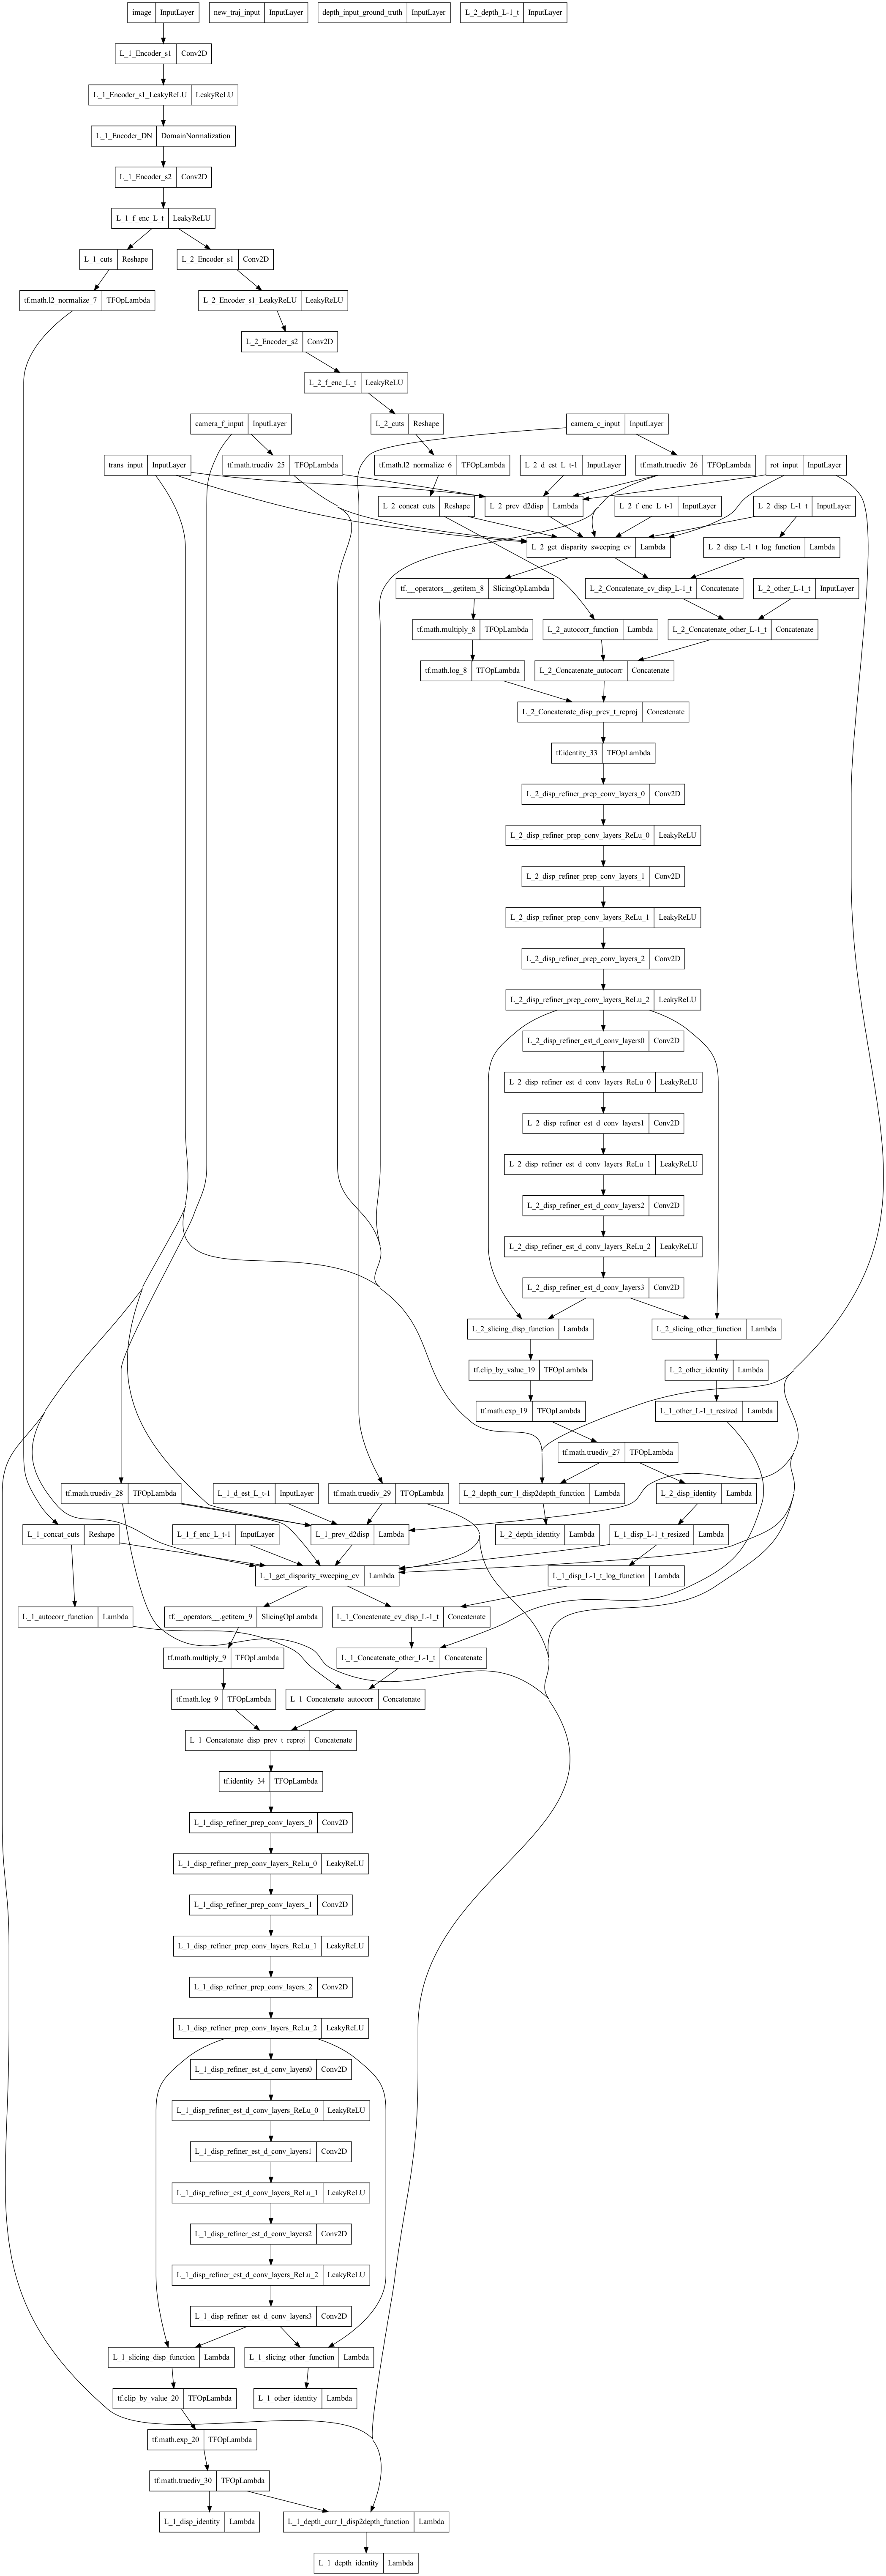

In [19]:
from keras.utils import vis_utils
name = "m4depth_model_L_" + str(n_lvl) + ".png"
vis_utils.plot_model(model_full, to_file=name, show_shapes=False, expand_nested=False)

In [2]:
from keras.utils import vis_utils

input_disp_refiner_1 = ks.Input(shape=(192, 192, 64,))
input_disp_refiner = ks.layers.Conv2D(
    16, 3, strides=(2, 2), padding='same',
    kernel_initializer=init, kernel_regularizer=reg)(input_disp_refiner_1)
input_disp_refiner = DispRefiner(regularizer_weight=regularizer_weight)(
    input_disp_refiner)
output_disp_refiner = (ks.layers.Conv2D(
    16, 3, strides=(2, 2), padding='same',
    kernel_initializer=init, kernel_regularizer=reg)(input_disp_refiner[0]),
                       input_disp_refiner[1])
model_disparity_refiner = ks.Model(inputs=input_disp_refiner_1,
                                   outputs=output_disp_refiner)

model_disparity_refiner.summary()
model_disparity_refiner.save(
    "m4depth_disparity_refiner.h5",
    save_format="h5",
)

NameError: name 'ks' is not defined